# ARIMA for Time Series Forecasting in Stock Data
ARIMA (Autoregressive Integrated Moving Average) is a powerful method for time series analysis and forecasting, particularly useful in stock market data. It combines autoregressive and moving average components to model and predict future stock prices based on historical trends.

In this project, we will implement the Box-Jenkins methodology for ARIMA modeling, which involves the following steps:

1. **Identification**: Assess the stationarity of the stock time series. If the series is non-stationary, apply differencing to achieve stationarity and generate the necessary differenced data. Utilize ACF and PACF plots to determine appropriate ARIMA parameters.

2. **Estimation**: Fit the ARIMA model to the historical stock data to estimate the model coefficients.

3. **Diagnostic Checking**: Evaluate the model's performance by analyzing residuals for patterns and checking for overfitting, ensuring the model is robust.

4. **Forecasting**: Use the fitted ARIMA model to forecast future stock prices.

This approach will provide valuable insights and predictions for stock performance, leveraging historical data to inform decision-making in real-world applications.

### Step 1. Install and import libraries

In [2]:
# %pip install sktime seaborn matplotlib pandas statsmodels pmdarima

Now that we've installed all of the libraries, we can import them into our environment:

In [ ]:
# Standard Libraries
import datetime
from math import sqrt

# Data Manipulation and Analysis Libraries
import pandas as pd
import numpy as np

# Data Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sktime.utils.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_pacf

# Statistical and Time Series Analysis Libraries
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Machine Learning and Forecasting Libraries
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sktime.split import temporal_train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

The data we'll use in this project is from the yfinance and available in yahoo yfinance. To see the detail of data loading and initial preprocessing kindly refer to 01_preprocess_explore_data notebook. On that notebooks We create the Pandas dataframe and then create a datetime index for the dataframe so that we can more easily work with it in sktime.

In [4]:
import os 
import sys
sys.path.append(os.path.join(os.path.abspath('..')))

In [5]:
spy_df = pd.read_csv('../../data/cleaned/cleaned_SPY.csv')
spy_df = spy_df[['Date', 'Adj Close']]
# Convert the 'Date' column to datetime
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df = spy_df.set_index(spy_df['Date']).drop('Date', axis=1)
spy_df.head()

,Adj Close
Date,
2015-01-02 00:00:00+00:00,206.380005
2015-01-05 00:00:00+00:00,204.169998
2015-01-06 00:00:00+00:00,202.089996
2015-01-07 00:00:00+00:00,201.419998
2015-01-08 00:00:00+00:00,204.009995


The statsmodels library requires that our DataFrame has a defined temporal frequency. To achieve this, we should resample the data using 'MS' (Month Start) to indicate that the DataFrame is structured with a monthly interval starting at the beginning of each month.

In [6]:
spy_df = spy_df.resample("MS").last()

### Step 3: Load the data and perform EDA

Before we start estimating what kind of ARIMA model, do some quick exploratory data analysis.

First, we can look at the statistics of our data set.

In [7]:
spy_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,118.0,331.767456,104.614038,190.020004,243.389999,298.479996,417.267502,581.289978


The large standard deviation and range suggest that the values in the series can vary significantly over time. This is a characteristic of non-stationary time series. Plotting the time series can also help show trend and seasonality.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Adj Close'>)

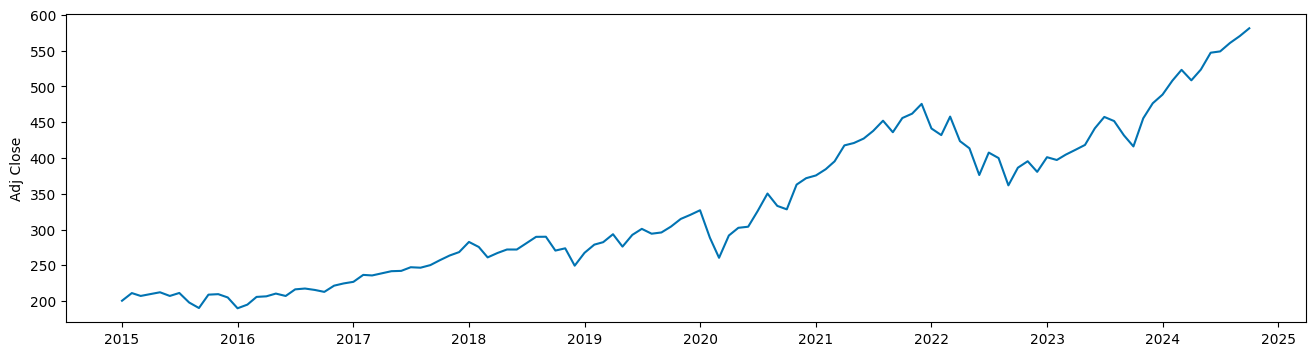

In [ ]:
plot_series(spy_df, markers=' ')

### Step 3: Check for Stationarity and Variance

In this step, we will assess whether our time series model is stationary. While ARIMA models can effectively handle non-stationarity caused by a unit root, they may not perform well in cases of other types of non-stationarity.

To classify a time series as stationary, it must meet three fundamental criteria:

1. **Constant Mean**: The mean of the series should not depend on time, indicating that it remains roughly constant, although some variance can be accounted for.
2. **Constant Variance**: The variance of the series should also be time-invariant. This property is known as homoscedasticity.
3. **Constant Covariance**: The covariance between terms, such as the k-th term and the (k + n)-th term, should not vary with time.

In essence, a stationary time series appears flat, exhibiting no trends, consistent variance over time, a stable autocorrelation structure, and no periodic fluctuations. It should closely resemble white noise. Given the characteristics of our time series, it is evident that it is likely non-stationary, indicating that our model will need to account for this.

To confirm the non-stationarity of our time series, we will employ two statistical tests: the **Augmented Dickey-Fuller (ADF) test** and the **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**. We will begin with the ADF test, which is a type of unit root test. The assumptions for the ADF test are as follows:

- **Null Hyp  Hypothesis (H0)**: The series is non-station ary, meaning it has a unit root.
- **Alternative Hypothesis (H1)**: The series is stationary, indicating it has no unit root.

If we cannot reject the null hypothesis, this suggests that the series is non-stationary. Specifically, when performing the ADF test, if the test statistic is less than the critical value and the p-value is less than 0.05, we reject the null hypothesis, which indicates that the time series is stationary.

In [ ]:
adf_result = adfuller(spy_df)
print(adf_result[1])

0.9956677216445835


We can see that the data is not currently stationary because the ADF test value is above 0.05. Running the KPSS test can help confirm this.

In [ ]:
kpss_result = kpss(spy_df)
print(kpss_result[1])

0.01


C:\Users\Hp\AppData\Local\Temp\ipykernel_11612\997242058.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(spy_df)


Here the KPSS test also indicates that our time series is not stationary becauase the KPSS test result is below 0.05.

Having two tests that may yield differing conclusions can be perplexing. If both the KPSS and ADF tests agree that the series is stationary, we can confidently consider it stationary, and there will be no need to include a differencing term in the ARIMA model.

If the ADF test identifies a unit root while the KPSS test indicates that the series is stationary around a deterministic trend, this suggests that the series is trend-stationary. In this case, we will need to detrend the series. This can be accomplished by differencing the time series using the diff method or applying a Box-Cox transformation to remove the trend.

Conversely, if the ADF test does not find a unit root but the KPSS test suggests that the series is non-stationary, then the series is considered difference stationary. In this scenario, we will need to difference the data before inputting it into our autoregressive model.

If both the KPSS and ADF tests agree that the series is non-stationary, we will treat it as non-stationary and will need to difference the data prior to using it in our autoregressive model.

To address these issues, we will utilize the decomposition method to identify and remove any components from the time series that may be contributing to its non-stationarity.

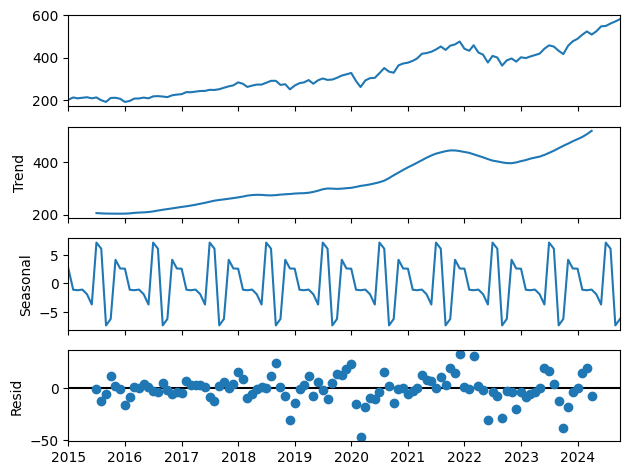

In [ ]:
result = seasonal_decompose(spy_df, model='additive')
result.plot()
plt.show()

Since this is a little difficult to see we can run the decompose function on a subset of the data, in this case only seeing the first 48 months of the data set.

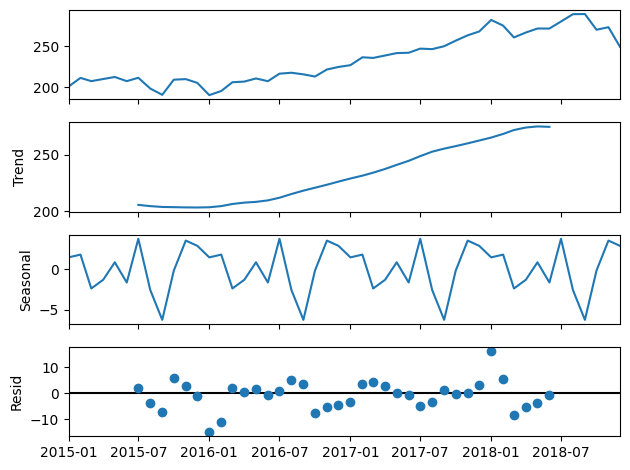

In [ ]:
result = seasonal_decompose(spy_df[:48], model='additive')
result.plot()
plt.show()

The time series decomposition plot reveals a time series with a clear upward trend and a yearly seasonal pattern. However, the plot also highlights increasing variability over time, indicating non-stationarity.

While ARIMA models are effective for handling trend and seasonality, they may struggle with the increasing variance. 

When we encounter heteroskedasticity in a time series it's common to take a log transformation to manage it. One tool for doing this is the Box-Cox transformation. The boxcox method takes a lambda parameter which is defined as follows:

We can apply a Box-Cox transformation to the data using the `boxcox` method.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='Adj Close'>)

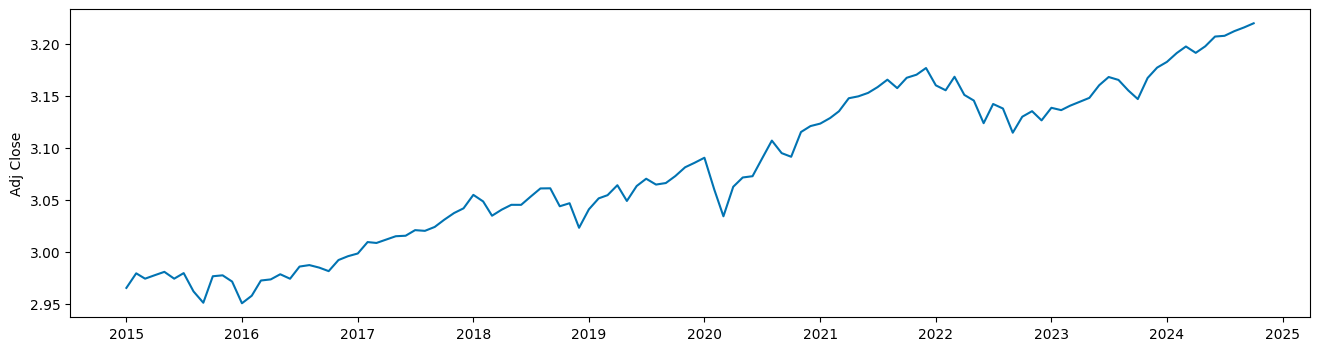

In [ ]:
spy_df['Adj Close'],fitted_lambda= boxcox(spy_df['Adj Close'],lmbda=None)
plot_series(spy_df['Adj Close'], markers=' ')

Let's see the first five rows of the data set.

In [14]:
spy_df.head()

,Adj Close
2015-01-01 00:00:00+00:00,2.965166
2015-02-01 00:00:00+00:00,2.979212
2015-03-01 00:00:00+00:00,2.974062
2015-04-01 00:00:00+00:00,2.977449
2015-05-01 00:00:00+00:00,2.980632


After applying the Box-Cox transformation to the time series data, the values have significantly decreased from a range of around 200 (before the transformation) to a range around 2-3 (after the transformation).

Even though the trend is still present, but the variance has decreased enough that we can investigate how ARIMA models will fit our data. 

### Step 4. Plot auto-correlations

First, create a test train split that can be used both train our model and then test the efficacy of that model. We'll hold out the last 24 values of the data set as a testing set.

In [ ]:
train, test = temporal_train_test_split(spy_df, test_size=24)

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

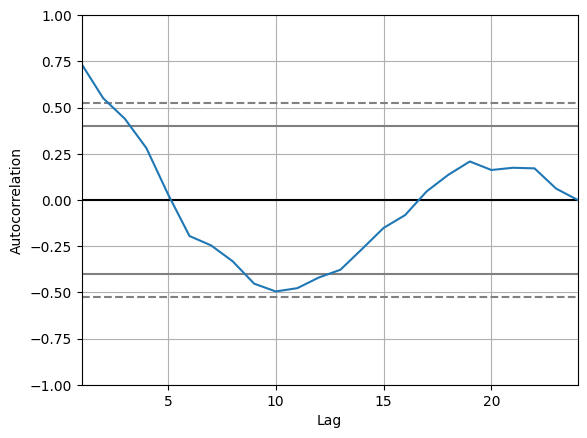

In [ ]:
autocorrelation_plot(train[-24:])

Across 24 time units, the detrended series still shows a positive but decreasing correlation at lags 18 and 22 and a negative and decreasing correlation at lags 10, and 20. This would indicate that our time series still has a seasonality component to it. The only one that is outside of the critical range of 0.5 to -0.5 though is at 2, so that might indicate a value for the autoregressive component of our ARIMA model.

It is also a good idea to check the Partial Autocorrelation Function (PACF) as well. A partial correlation is a conditional correlation. As an example, think of a time series where the time series contains values for Y at Xt, Xt+1, and Xt+2. The partial correlation between Y and Xt+2 is the correlation between the variables determined taking into account how both Y and Xt+2 are related to Xt and Xt+1.

The PACF is helpful in determining the order of the AR part of the ARIMA model. It is also useful to determine or validate how many seasonal lags to include in the forecasting equation of a moving average based forecast model for a seasonal time series. This is called the seasonal moving average (SMA) order of the process.

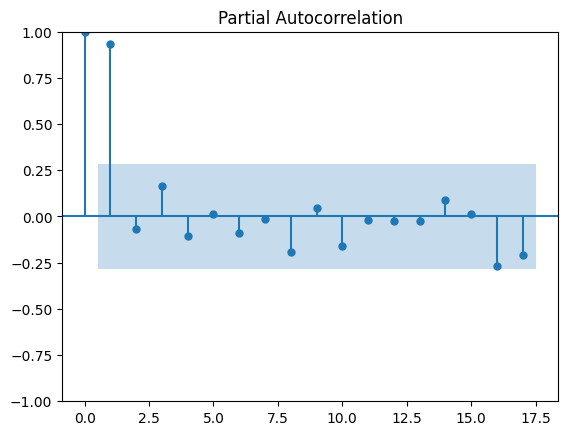

In [ ]:
plot_pacf(train[-48:])
plt.show()

Again, The value outside the critical range is at lag 2. This indicates a significant autocorrelation at lag 2, meaning the current value in the time series is strongly influenced by its immediate past value.

A rough rubric for when to use Autoregressive terms in the model is when:

* ACF plots show autocorrelation decaying towards zero
* PACF plot cuts off quickly towards zero
* ACF of a stationary series shows positive at lag 1

A rough rubric for when to use moving average terms in the model is when:

* The ACF is negatively autocorrelated at lag 1
* ACF that drops sharply after a few lags
* PACF decreases gradually rather than suddenly

We can see from our two plots that our ACF plot shows a positive value at lag 2 and that the PACF cuts off imediately. This might indicate that we should use an AR term in our model.

### Step 5. Train the ARIMA model

Now that we have a sense of what kinds of ARIMA model might represent our data well, we can begin training a model.

First, we can call the arima function without a seasonal component, which has the following parameters:

ARIMA(dataset, order)

The order is a tuple with 3 values:

* p: the order of the autoregressive term
* d: degree of differencing
* q: the number of moving average terms

Since we saw characteristics in the ACF and PACF plots that might indicate an AR model, we'll create a first-order autoregressive model. We use the checkresiduals function to generate graphs of the residuals, the ACF, and the distribution of the residuals. We'll use an autoregressive term and a first difference term because our data exhibits non-stationarity.

In [ ]:
model = ARIMA(train, order=(2,1,0))
model_fit = model.fit()

Now let's look at the summary of the generated model.

In [19]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   94
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 285.893
Date:                Tue, 12 Nov 2024   AIC                           -565.786
Time:                        21:37:32   BIC                           -558.189
Sample:                    01-01-2015   HQIC                          -562.719
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0747      0.091     -0.823      0.410      -0.252       0.103
ar.L2         -0.2175      0.098     -2.230      0.026      -0.409      -0.026
sigma2         0.0001   1.83e-05      6.819      0.0

There is a lot to look at here. We can see the coefficients for the model specification and some of the calculated statistics for it:

* **sigma2**: this represents the variance of the residual values, lower is better
* **log likelihood**: this is maximum likelihood estimation for the ARIMA model, higher is better
* **aic**: a measure of the goodness of fit and the parsimony of the model, lower is better

Let’s plot the residuals to ensure there are no patterns in them. We're hoping for a constant mean and variance.

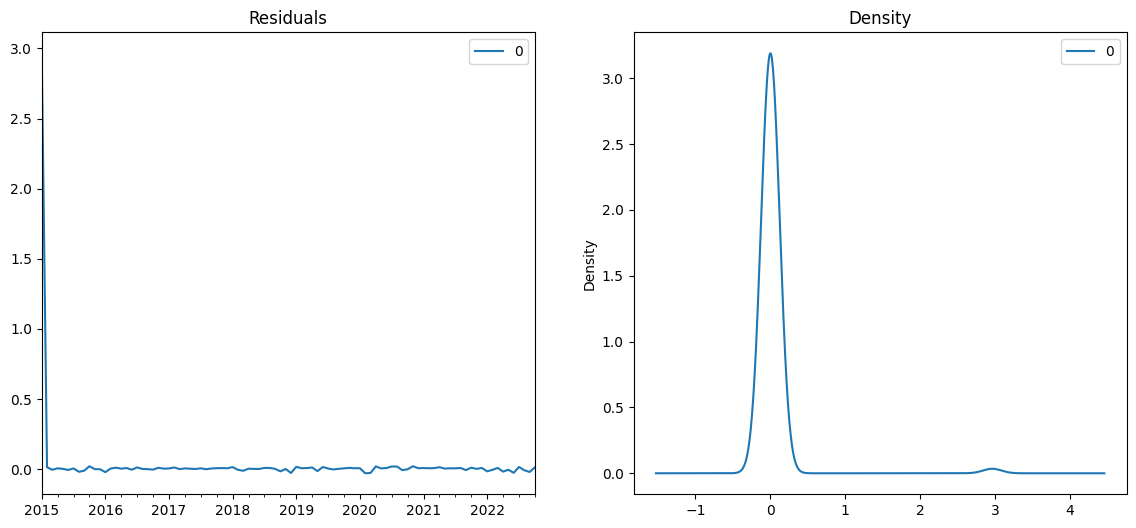

In [ ]:
# density plot of residuals
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

We can see that the residuals of time series model over time. Ideally, the residuals should be randomly distributed around zero, indicating that the model has captured the underlying patterns in the data well.

It's time to see how the predictive power of the fitted model matches the test data. The test data can be added one time point at a time to the train data to allow the model to include the new data point in the training.

In [21]:
history = train
predictions = list()
# walk-forward validation
for t in range(len(test),0,-1):
    model = ARIMA(spy_df[:-t], order=(2,1,0));
    model_fit = model.fit();
    output = model_fit.forecast();
    yhat = output.iloc[0]
    predictions.append(yhat)

c:\Users\Hp\Desktop\Kifiya\week11\GMF-PortfolioForecasting\week11\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The output predictions are stored in a list called predictions so that the predictions can be graphed alongside the actual test values.

C:\Users\Hp\AppData\Local\Temp\ipykernel_11612\3572007134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'predictions'] = predictions.copy()


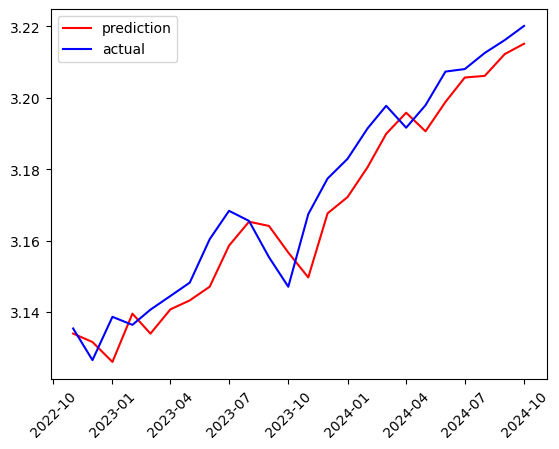

In [ ]:
test.loc[:,'predictions'] = predictions.copy()

plt.plot(test['predictions'], color='red', label='prediction')
plt.plot(test['Adj Close'], color='blue', label='actual')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

Let's check the root mean squared error.

In [ ]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test['predictions'], test['Adj Close']))
mae = mean_absolute_error(test['predictions'], test['Adj Close'])
mape = mean_absolute_percentage_error(test['predictions'], test['Adj Close'])

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.008
Test MAE: 0.007
Test MAPE: 0.002


An RMSE of 0.008 indicates that, on average, our model's predictions deviate from the actual values by 0.008 units. This is a relatively low error, suggesting that our model is performing well.

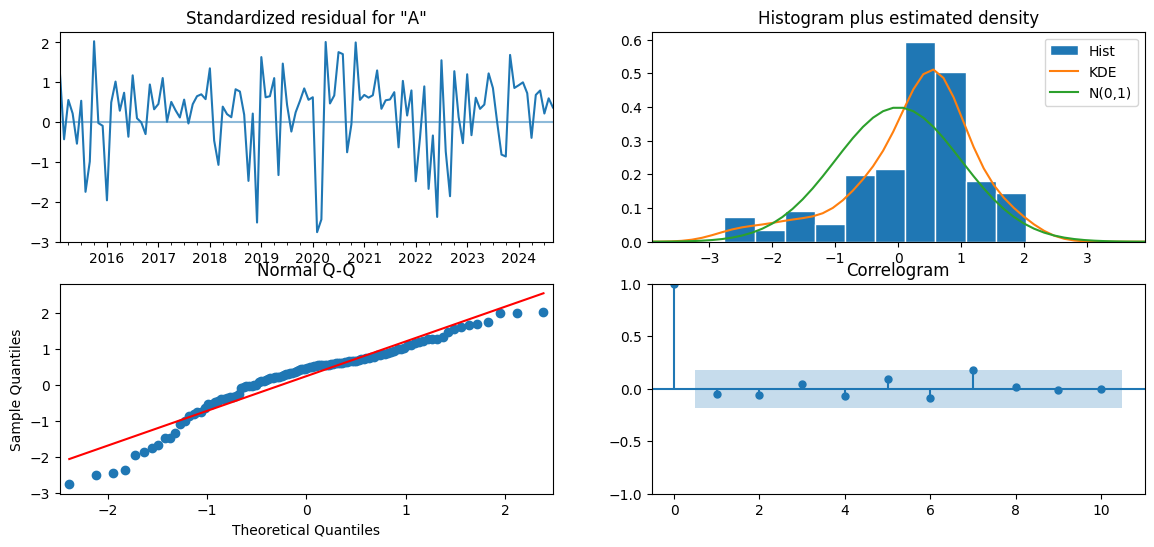

In [ ]:
model_fit.plot_diagnostics(figsize=(14, 6))
plt.show()

Based on these diagnostic plots, the model appears to be a good fit for the data. The residuals are randomly distributed, normally distributed, and not significantly autocorrelated. This suggests that the model is capturing the underlying patterns in the data effectively and that there are no significant systematic errors.

In [25]:
history = train
# Make predictions
auto_predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

C:\Users\Hp\AppData\Local\Temp\ipykernel_11612\990653491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'auto_predictions'] = auto_predictions.copy()


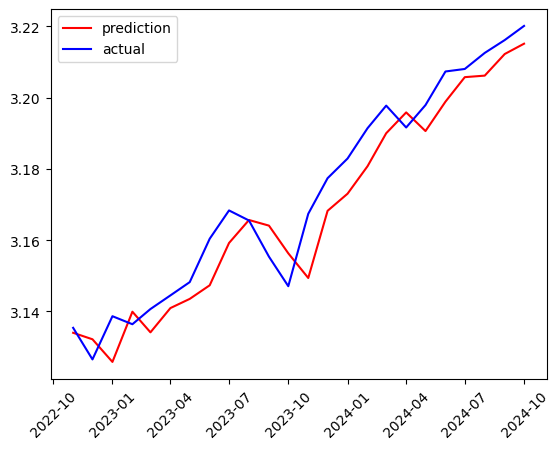

In [ ]:
test.loc[:, 'auto_predictions'] = auto_predictions.copy()

plt.plot(test['auto_predictions'], color='red', label='prediction')
plt.plot(test['Adj Close'], color='blue', label='actual')
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate Evaluation Metrics
rmse = sqrt(mean_squared_error(test['auto_predictions'], test['Adj Close']))
mae = mean_absolute_error(test['auto_predictions'], test['Adj Close'])
mape = mean_absolute_percentage_error(test['auto_predictions'], test['Adj Close'])

print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.008
Test MAE: 0.007
Test MAPE: 0.002
